# ECE 498 DS Mini Project 2

## Akhilesh Somani - somani4,
## Gowtham Kuntumalla - gowtham4,
## Manan Mehta - mananm2

# Task 1: Data Cleaning and Visual Inspection

## 0. Getting Started With the Data

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
he0_df_org=pd.read_csv("RelativeAbundance_HE0.csv")
he1_df_org=pd.read_csv("RelativeAbundance_HE1.csv")

### 1. In the context of statistical analysis, why do biologists need multiple samples to identify microbes with significantly altered abundance?

Biologists need multiple samples to be sure that the data is statistically significant. Hypothesis needs to be backed by data. This helps them to conclude, with a greater confidence, which microbes are present in more numbers than usual.

### 2. How many samples were analyzed?
Number of samples analyzed were: 764

In [3]:
len(he0_df_org.set_index("Microbe Name").columns)

764

### 3. How many microbes were identified?
Number of different micorbes idenified were: 149

In [4]:
he0_df_org.groupby("Microbe Name").count().sum()[0]

149

## 1. Bayesian Network for Quality Control

### a. Joint Probability Factorization
T = storage temp,
M = collection method,
C = contamination,
L = Lab time,
Q = quality

$$ P(joint) = P(Q,C,L,M,T) = P(Q|C,L,M,T) * P(C|M,T,L) * P(M|T,L) * P(T|L) * P(L)$$ 
$$ P(Q,C,L,M,T) = P(Q|C,L) * P(C|M,T) * P(M) * P(T) * P(L)$$

### b. Parameters Required
Number of values taken by:
C=2,
L=2,
T=2,
M=2,
Q=2

Parameters needed are: (2x2)+(2x2)+1+1+1 = 11

### c. Constructing Probability Tables

In [5]:
qc_df=pd.read_csv("QualityControl.csv")

In [6]:
#P(T),P(M),P(T)
feature=["strtmp","coll","labtime"]
sub_features=[["cold","cool"],["nurse","patient"],["short","long"]]
for i in range(3):
    z=qc_df.groupby(feature[i]).count()
    z.loc[sub_features[i][0]], z.loc[sub_features[i][1]] = z.loc[sub_features[i][0]]/z.sum(), z.loc[sub_features[i][1]]/z.sum()
    print(z.loc[:,'qual'])
    print("\n")

strtmp
cold    0.8982
cool    0.1018
Name: qual, dtype: float64


coll
nurse      0.8976
patient    0.1024
Name: qual, dtype: float64


labtime
long     0.2044
short    0.7956
Name: qual, dtype: float64




In [7]:
#P(Q|C,L)
z=qc_df.groupby(["cont","labtime","qual"]).count()
temp=qc_df.groupby(["cont","labtime"]).count()
for i in ['high','low']:
    for j in ['long','short']:
        for k in ['bad','good']:
            z.loc[i,j,k]=z.loc[i,j,k]/temp.loc[i,j]
        
print(z.loc[:,'strtmp'])

cont  labtime  qual
high  long     bad     0.966102
               good    0.033898
      short    bad     0.064257
               good    0.935743
low   long     bad     0.080997
               good    0.919003
      short    bad     0.042907
               good    0.957093
Name: strtmp, dtype: float64


In [8]:
#P(C|M,T)
z=qc_df.groupby(["coll","strtmp","cont"]).count()
temp=qc_df.groupby(["coll","strtmp"]).count()
for i in ['nurse','patient']:
    for j in ['cold','cool']:
        for k in ['high','low']:
            z.loc[i,j,k]=z.loc[i,j,k]/temp.loc[i,j]
        
print(z.loc[:,'qual'])

coll     strtmp  cont
nurse    cold    high    0.043983
                 low     0.956017
         cool    high    0.088435
                 low     0.911565
patient  cold    high    0.076577
                 low     0.923423
         cool    high    0.838235
                 low     0.161765
Name: qual, dtype: float64


### d. Final Probability Tables: Calculate P(Quality|Storage Temp, Collection Method, Lab Time)

In [9]:
#P(Q|T,M,L)

cpd=qc_df.groupby(["strtmp","coll","labtime","qual"]).count()
temp=qc_df.groupby(["strtmp","coll","labtime"]).count()

for i in ['cold','cool']:
    for j in ['nurse','patient']:
        for k in ['long','short']:
            for l in ['bad','good']:
                cpd.loc[i,j,k,l]=cpd.loc[i,j,k,l]/temp.loc[i,j,k]
        
print(cpd)

                                 cont
strtmp coll    labtime qual          
cold   nurse   long    bad   0.112038
                       good  0.887962
               short   bad   0.044888
                       good  0.955112
       patient long    bad   0.137931
                       good  0.862069
               short   bad   0.056022
                       good  0.943978
cool   nurse   long    bad   0.177215
                       good  0.822785
               short   bad   0.027624
                       good  0.972376
       patient long    bad   0.882353
                       good  0.117647
               short   bad   0.039216
                       good  0.960784


### e. Cleaning the dataset

In [10]:
bi_he0_df=pd.read_csv('BayesInferenceHE0.csv')
bi_he1_df=pd.read_csv('BayesInferenceHE1.csv')

bi_he0_df['prob']=0
bi_he1_df['prob']=0

bi_he0_df['prob']=[cpd.loc[bi_he0_df['strtmp'].iloc[i],bi_he0_df['coll'].iloc[i],bi_he0_df['labtime'].iloc[i],'bad'][0]\
                           for i in range(len(bi_he0_df))]

bi_he1_df['prob']=[cpd.loc[bi_he1_df['strtmp'].iloc[i],bi_he1_df['coll'].iloc[i],bi_he1_df['labtime'].iloc[i],'bad'][0]\
                           for i in range(len(bi_he1_df))]

idx1=(bi_he0_df['prob']>0.5)
idx2=(bi_he1_df['prob']>0.5)

#Indices to drop in the pandas dataframe
i1=bi_he0_df['SampleName'][idx1].index
i2=bi_he1_df['SampleName'][idx2].index
print("Number of data samples dropped are {0} and {1}".format(len(i1),len(i2)))

#Columns to drop in the pandas dataframe
col1 = [bi_he0_df.loc[i1, 'SampleName'].iloc[i] for i in range(len(bi_he0_df.loc[i1, 'SampleName']))]
col2 = [bi_he1_df.loc[i2, 'SampleName'].iloc[i] for i in range(len(bi_he1_df.loc[i2, 'SampleName']))]

he0_df = he0_df_org.drop(columns=col1)
he1_df = he1_df_org.drop(columns=col2)

Number of data samples dropped are 65 and 65


## 2. Data Standardization

### 1. Verify Relative Abundance

In [11]:
ctr = 0
for i in range(1,len(he0_df.sum())):
    if abs(he0_df.sum().iloc[i] - 1.0) > 1e-10:
        print("Relative abundance does not add up to 1 for sample at index:", i)
        ctr += 1
        
if ctr == 0:
    print("All data samples in HE0 follow the contraint! :)")
else:
    print("Some data samples in HE0 do not follow the contraint. Need to remove them.")

All data samples in HE0 follow the contraint! :)


In [12]:
ctr = 0
for i in range(1,len(he1_df.sum())):
    if abs(he1_df.sum().iloc[i] - 1.0) > 1e-10:
        print("Relative abundance does not add up to 1 for sample at index:", i)
        ctr += 1
        
if ctr == 0:
    print("All data samples in HE1 follow the contraint! :)")
else:
    print("Some data samples in HE1 do not follow the contraint. Need to remove them.")

All data samples in HE1 follow the contraint! :)


### 2. Discussion on Relative Abundance Data

While using relative abundance data, we have scaled the variance of the data and hence, we give equal emphasis to the variation for each bacteria. 

However, by doing so, we do not know the exact number of the bacteria present, which may be important to know rather than just the relative abundance. 

For eg - A reltive abundance of 0.5:0.5 might mean 100:100 bacteria or 100k:100k bacteria. If there is a contraint on the number of bacteria to do some analysis, then this information is lost by scaling it

### 3. Visual Inspection

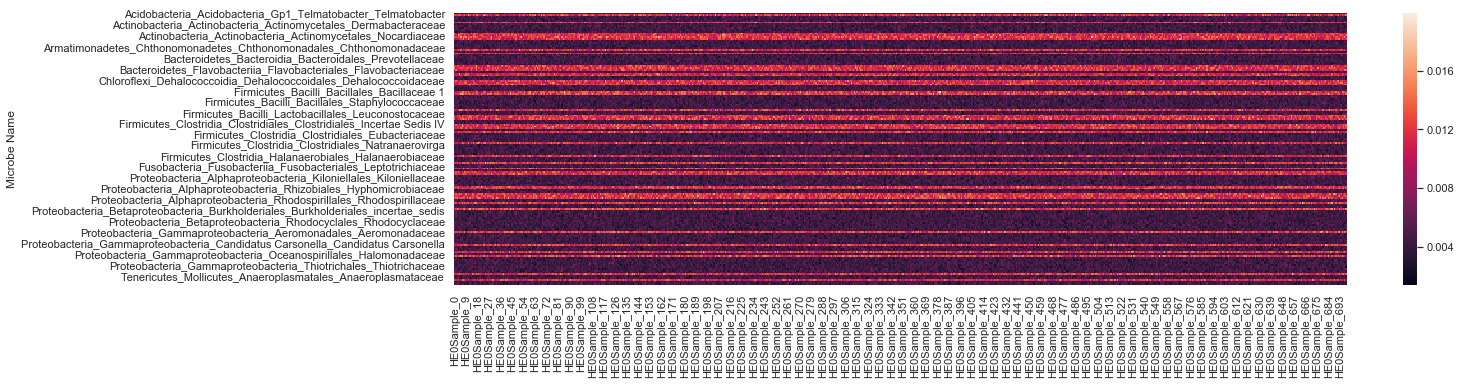

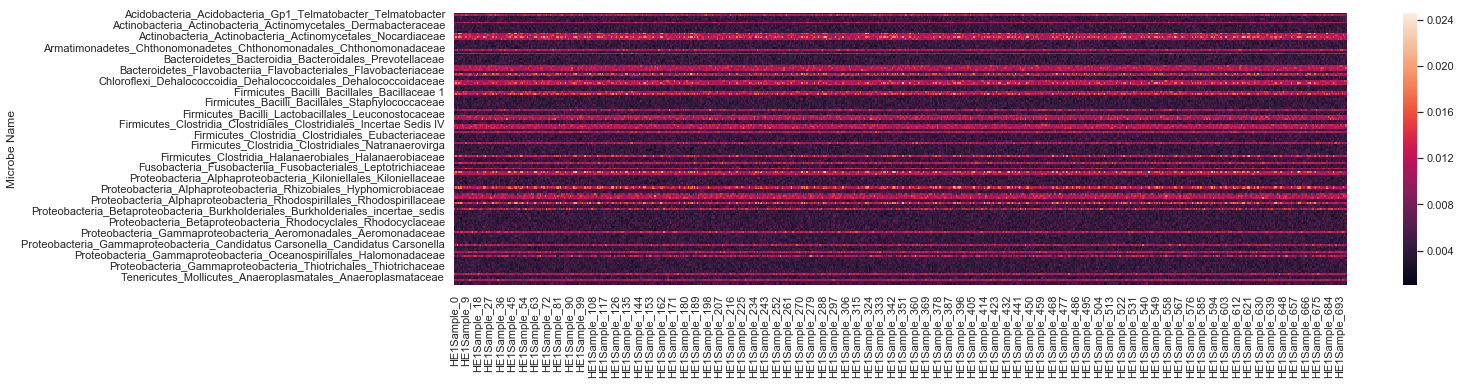

In [13]:
he0_df_heatmap = he0_df.set_index('Microbe Name')
plt.figure(figsize = (20,5))
ax = sns.heatmap(he0_df_heatmap)
plt.savefig('heatmap_he0.png', bbox_inches='tight')

he1_df_heatmap = he1_df.set_index('Microbe Name')
plt.figure(figsize = (20,5))
ax = sns.heatmap(he1_df_heatmap)
plt.savefig('heatmap_he1.png', bbox_inches='tight')

# Task 2: Statistical Analysis

## 1. Kolmogorov-Smirnov (KS) Test

### a. p-value for Two-Sample KS Test

In [14]:
ctr = 0
alpha = 0.05
for i in range(len(he0_df)):
    _, p_value = sp.stats.ks_2samp(he0_df.iloc[i,1:].values, he1_df.iloc[i,1:].values)
    #print("P-Value for bacteria {0} is {1}".format(he0_df.iloc[i][0], p_value))
    if p_value <= alpha:
        ctr += 1
        #print("Bacteria {0} has altered abundance level".format(he0_df.iloc[i][0]))
        
print("Number of bacteria with altered proportions are", ctr)

Number of bacteria with altered proportions are 37


### b. Null Hypothesis of the KS Test in our Context

Null Hypothesis: Ho: Both bacteria samples are drawn from the same sample (i.e. no significant variance between them)

### c. Number of Genes with Significantly Altered Expression at Various Alpha Values

In [30]:
all_alphas = [0.1, 0.05, 0.01, 0.005, 0.001]
ctr = np.zeros(len(all_alphas))
j = 0
p_value_observed = []

for alpha in all_alphas:
    for i in range(len(he0_df)):
        d , p_value = sp.stats.ks_2samp(he0_df.iloc[i,1:].values, he1_df.iloc[i,1:].values)
        if alpha == 0.05:
            p_value_observed.append(p_value)
        if p_value < alpha:
            ctr[j] += 1
    j +=1 

print("Number of bacteria with altered proportions are", ctr)

Number of bacteria with altered proportions are [50. 37. 27. 26. 21.]


## 2. Multiple Testing

### a. P-value

### b. P-value Distribution

### c. Expected Number of Significant p-values

### d. Q-Q plot of p-values

#### i. 

In [32]:
p_values_expected = np.random.uniform(0,1, (149,))

#### ii. 

In [33]:
p_log_obs = -np.log10(p_value_observed)
p_log_exp = -np.log10(p_values_expected)

#### iii. 

In [34]:
p_log_exp.sort()
p_log_obs.sort()

#### iv. 

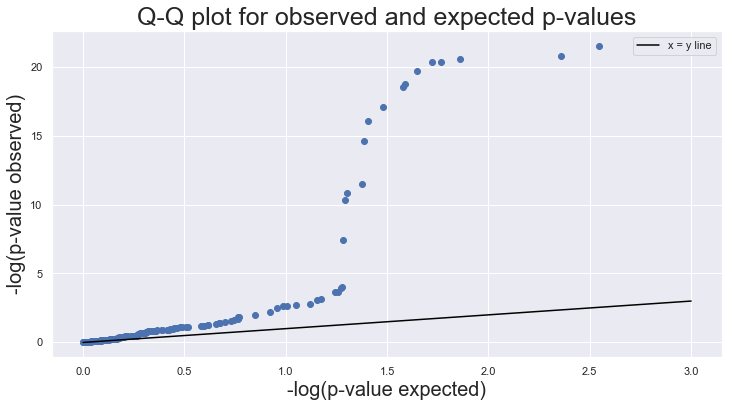

In [58]:
x = p_log_exp
y = p_log_obs

plt.figure(figsize=(12,6))
plt.scatter(x,y)
plt.show
plt.xlabel('-log(p-value expected)', size=20)
plt.ylabel('-log(p-value observed)', size=20)
plt.title('Q-Q plot for observed and expected p-values', size=25)
plt.plot([0,3],[0,3], label = 'x = y line', color = 'black')
plt.legend()

#### v. 

#### vi. 

### e. Follow-up Questions

#### i. 

#### ii. 

# Task 3: Dimensionality Reduction and Clustering

## 1. PCA

### a. Performing PCA


### b. Ordering Components

### c. Scatter Plot of Microbe Abundance

## 2. t-SNE

### a. Performing t-SNE

### b. Comparing with PCA

## 3. Clustering

### a. K-Means

### b. GMM

### c. Single and Complete Linkage Hierarchical

### d. Single vs Complete Link Hierarchical Clustering

### e. Comparing Clustering Techniques

### f. What do Clusters Represent

### g. Deciding on Number of Clusters

# Task 4: Interpreting Results

## 1. Identify Microbes with Altered Abundance Levels

### a. Determine if each HE1 Subpopulation shows altered abundance levels

### b. Identify Most Similar HE0 Clusters to Affected HE1 Clusters

### c. Identify Microbes with Significantly Altered Relative Abundance

## 2. Identify How Abundance Changes

### a. Microbes which increase and decrease

### b. Biological Relations